In [2]:
import sys
import json
import string
from collections import defaultdict


def rerender_chord(chord):
    out = ""
    had_hyphen = False
    had_mid = False
    for i in chord:
        if i == "-":
            out += i
            had_hyphen = True
        elif i in "*EU" and not had_hyphen:
            out += "-" + i
            had_hyphen = True
        elif i not in "AO*EU" and had_mid and not had_hyphen:
            out += "-" + i
            had_hyphen = True
        else:
            out += i
            if i in "AO":
                had_mid = True
    return out


def rerender_chords(s):
    return "/".join(
        rerender_chord(i.strip())
        for i in s.split("/") if i.strip()
    )


def valid(s):
    return set(s) <= set(string.ascii_uppercase + "*#-/ ")

In [3]:
with open("../plover/plover/assets/main.json") as f:  # ../plover is the cloned Plover repository from https://github.com/openstenoproject/plover
    dictionary = json.load(f)

dict_rev = defaultdict(lambda: [])
for k, v in dictionary.items():
    if valid(k):
        dict_rev[v.lower()].append(rerender_chords(k))

In [118]:
min_weights = defaultdict(lambda: float("inf"))
min_idxs = defaultdict(lambda: float("inf"))
included_translations = defaultdict(lambda: 0)
included_translations_max = defaultdict(lambda: 0)
data = defaultdict(lambda: [])
times = []

with open("translated-final") as f:
    for i in f:
        item = json.loads(i)
        word = item["word"]
        data[word].append(item)
        times.append(item["time"])
        if word in dict_rev:
            plover_candidates = dict_rev[item["word"]]

            first_weight = item["translations"][0]["weight"]
            min_weight = min(
                (
                    j["weight"] - first_weight
                    for j in item["translations"]
                    if j["translation"] in plover_candidates
                ),
                default=float("inf")
            )
            min_idx = min(
                (
                    idx
                    for idx, j in enumerate(item["translations"])
                    if j["translation"] in plover_candidates
                ),
                default=float("inf")
            )

            included = sum(
                1
                for j in item["translations"]
                if j["translation"] in plover_candidates
            )

            min_weights[word] = \
                min(min_weights[word], min_weight)
            min_idxs[word] = \
                min(min_idxs[word], min_idx)

            included_translations[word] += included
            included_translations_max[word] += \
                len(plover_candidates)


In [119]:
import matplotlib
import matplotlib.pyplot as plt

# https://blog.timodenk.com/exporting-matplotlib-plots-to-latex/
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    "figure.figsize" : (2.5, 1.75)
})
matplotlib.rcParams['text.latex.preamble'] = r'\renewcommand{\mathdefault}[1][]{}' # https://git.ligo.org/lscsoft/bilby/-/issues/482

In [120]:
%matplotlib inline

In [121]:
(counts := (sum(1 for i in included_translations.values() if i == 0), len(included_translations)))

(13189, 40494)

In [122]:
counts[0] / counts[1] * 100

32.57025732207241

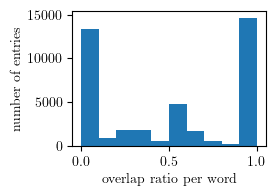

In [123]:
plt.hist([v / included_translations_max[k] for k, v in included_translations.items()])
plt.ylabel("number of entries")
plt.xlabel("overlap ratio per word")
plt.savefig("ratiohist.pgf", bbox_inches='tight')
plt.show()
plt.close()

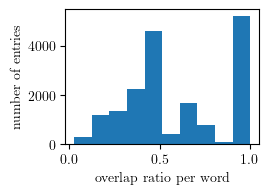

In [124]:
plt.hist([v / included_translations_max[k] for k, v in included_translations.items() if v != 0 and included_translations_max[k] > 1])
plt.ylabel("number of entries")
plt.xlabel("overlap ratio per word")
plt.savefig("ratiohist2.pgf", bbox_inches='tight')
plt.show()
plt.close()

In [125]:
import random

In [126]:
[(i, dict_rev[i], [k["translation"] for j in data[i] for k, _ in zip(j["translations"], range(3))]) for i in random.choices([k for k, v in included_translations.items() if v == 0], k=20)]

[('abu', ['A-B/SKWR-U'], ['A-B', 'A-*B', 'PWAO-U']),
 ('indiscriminate',
  ['-EUPB/TK-EUS/SKR-EUPL/KR-*EUPL/TPHA-T',
   '-EUPB/TK-EUS/KRA-EUPL/TPHA-T',
   '-EUPB/TK-EUS/KR-EUPL/TPHA-EUT',
   '-EUPBD/SKR-EUPL/TPHA-PBT',
   '-EUPBDZ/KR-EUPL/TPHA-EUT'],
  ['-EUPBD/SKR-EUPLT', '-EUPBD/SKR-EUPL/TPHA-T', '-EUPBD/SKR-*EUPLT']),
 ('duchy', ['TK-UFP/KWR-EU'], ['TK-UFP', 'TK-*UFP', 'TK-U/KHAO-E']),
 ('spontaneously',
  ['SPA-*EUPBLS', 'SPA-EUPBLS', 'SPO-PB/TA-EUPB/SHR-EU'],
  ['SPO-PB/TA-EUPBLS', 'SPO-PB/TA-EUFPBL', 'SPO-PB/TA-EUPB/SHRAO-E']),
 ('grumpy',
  ['TKPWR-UFRP/P-EU', 'TKPWR-UPL/P-EU'],
  ['TKPWR-*UPL', 'TKPWR-UPL/PAO-E', 'TKPWR-UPL/P-E']),
 ('grouchy',
  ['TKPWRO-U/KH-EU', 'TKPWRO-UFP/KWR-EU', 'TKPWRO-UFP/KH-EU'],
  ['TKPWRO-UFP', 'TKPWRO-*UFP', 'TKPWRO-U/KHAO-E']),
 ('fallacy',
  ['TPA-L/S-EU', 'TPA-L/HRA/S-EU'],
  ['TPA-ELS', 'TPA-LS', 'TPA-EFL']),
 ('forgive',
  ['TPA-UR/TKPW-EUF', 'TPA-URG'],
  ['TPO-R/TKPW-*EUF',
   'TPO-R/TKPW-EUF',
   'TPO-RG/-*EUF',
   'TPO-R/TKPW-*EUF',
   'TP

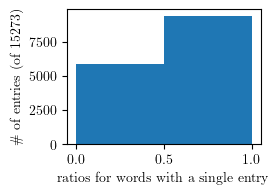

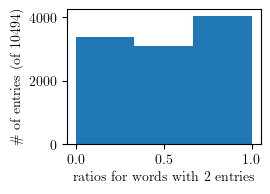

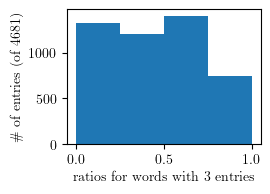

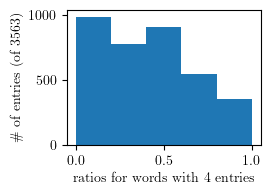

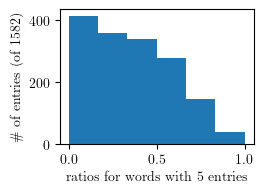

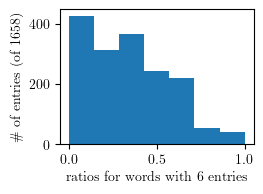

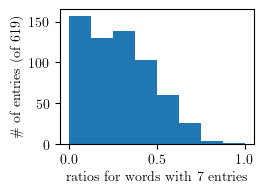

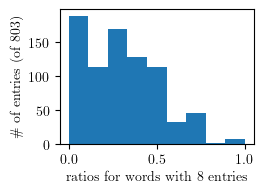

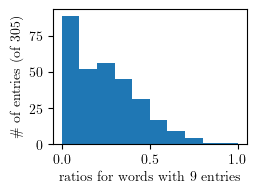

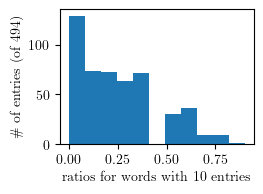

In [128]:
for i in range(1, 11):
    plt.hist([v / included_translations_max[k] for k, v in included_translations.items() if included_translations_max[k] == i], bins=i + 1)
    total = len([v / included_translations_max[k] for k, v in included_translations.items() if included_translations_max[k] == i])
    plt.ylabel(f"\# of entries (of {total})")
    plt.xlabel(f"ratios for words with {i} entries" if i > 1 else "ratios for words with a single entry")
    plt.savefig(f"ratiohist-it{i}.pgf", bbox_inches='tight')
    plt.show()
    plt.close()

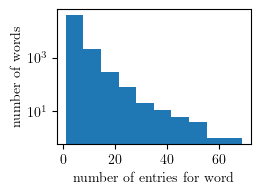

In [129]:
plt.hist([included_translations_max[k] for k, v in included_translations.items()], log=True)
plt.ylabel("number of words")
plt.xlabel("number of entries for word")
plt.savefig("wordentryhist.pgf", bbox_inches='tight')
plt.show()
plt.close()

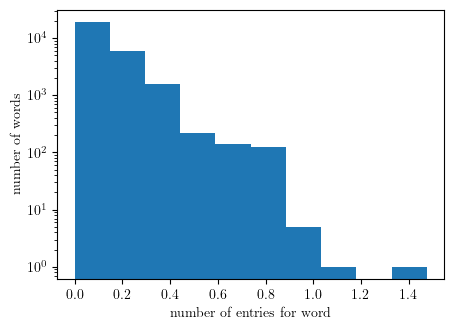

In [184]:
plt.rcParams["figure.figsize"] = (5, 3.5)
plt.hist([i for i in min_weights.values()  if i != float("inf")],log=True)
plt.ylabel("number of words")
plt.xlabel("number of entries for word")
plt.savefig("weighthist.pgf", bbox_inches='tight')
plt.show()
plt.close()

(array([2.7302e+04, 7.5767e+04, 2.7036e+04, 4.1360e+03, 4.4000e+01,
        3.0000e+00, 3.0000e+00, 3.0000e+00, 0.0000e+00, 3.0000e+00]),
 array([0.00023437, 0.00260455, 0.00497473, 0.00734491, 0.00971509,
        0.01208528, 0.01445546, 0.01682564, 0.01919582, 0.021566  ,
        0.02393618]),
 <BarContainer object of 10 artists>)

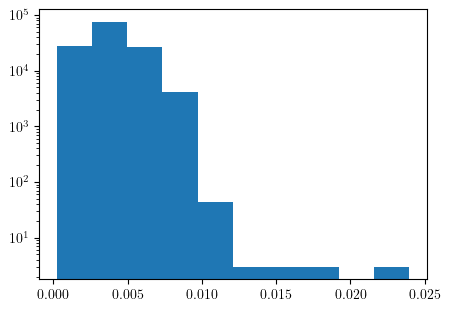

In [185]:
plt.hist([(j["translations"][-1]["weight"] - j["translations"][0]["weight"]) / len(j["translations"]) for i in data.values() for j in i], log=True)

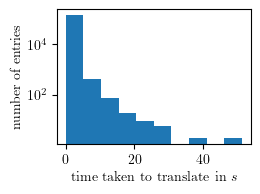

In [187]:
plt.rcParams["figure.figsize"] = (5/2, 3.5/2)
plt.hist([i for i in times if i < 600], log=True)
plt.xlabel("time taken to translate in $s$")
plt.ylabel("number of entries")
plt.savefig("timehist.pgf", bbox_inches='tight')
plt.show()
plt.close()

In [188]:
ts = times[:]
ts.sort()

In [189]:
running_sum = 0
full_sum = sum(ts) + 1354.578745681094
cutoff = 100
for idx, i in enumerate(ts):
    if running_sum >= cutoff:
        break
    running_sum += i
idx, len(ts), idx / (len(ts) + 1) * 100, 100 - idx / (len(ts) + 1) * 100, full_sum

(7834, 134297, 5.833296102696988, 94.16670389730301, 44796.27514854632)

In [190]:
len([i for i in ts if i <= 1]) / (len(ts) + 1)

0.9371770242296982

In [191]:
(sum(i for i in ts if i > 1) + 1354.578745681094) / full_sum

0.4808295327683572

In [192]:
cumts = []
cumulative = 0
for i in ts:
    cumulative += i
    cumts.append(cumulative)

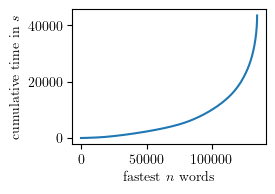

In [195]:
plt.plot(range(1, len(cumts) + 1), cumts)
plt.xlabel("fastest $n$ words")
plt.ylabel("cumulative time in $s$")
plt.savefig("timecum.pgf", bbox_inches='tight')
plt.show()
plt.close()